<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/bro.png" width="100px"></div>

# Zeek to Spark Clustering
In this notebook we will pull Bro data into Spark then do some analysis and clustering. The first step is to convert your Zeek log data into a Parquet file, for instructions on how to do this (just a few lines of Python code using the BAT package) please see this notebook:

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/parquet.png" width="300px"></div>

### How to convert Zeek log to Parquet Notebook
- [Bro to Spark (and Parquet)](https://nbviewer.jupyter.org/github/SuperCowPowers/bat/blob/master/notebooks/Bro_to_Spark.ipynb)

Apache Parquet is a columnar storage format focused on performance. Parquet data is often used within the Hadoop ecosystem and we will specifically be using it for loading data into Spark.

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/mllib.png" width="200px"></div>
<div style="float: right; margin: 30px 0px 0px 0px"><img src="images/spark.png" width="200px"></div>

### Software
- Zeek/Bro Analysis Tools (BAT): https://github.com/SuperCowPowers/bat
- Parquet: https://parquet.apache.org
- Spark: https://spark.apache.org
- Spark MLLib: https://spark.apache.org/mllib/

### Data
- About 1/2 million rows of a Zeek dns.log
- Sec Repo: http://www.secrepo.com (no headers on these)
- SuperCowPowers: [data.kitware.com](https://data.kitware.com/#collection/58d564478d777f0aef5d893a) (with headers)

In [1]:
# Third Party Imports
import pyspark
from pyspark.sql import SparkSession

# Local imports
import bat

# Good to print out versions of stuff
print('BAT: {:s}'.format(bat.__version__))
print('PySpark: {:s}'.format(pyspark.__version__))

BAT: 0.3.7
PySpark: 2.4.4


<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark.png" width="200px"></div>

# Spark It!
### Spin up Spark with 4 Parallel Executors
Here we're spinning up a local spark server with 4 parallel executors, although this might seem a bit silly since we're probably running this on a laptop, there are a couple of important observations:

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark_jobs.png" width="400px"></div>

- If you have 4/8 cores use them!
- It's the exact same code logic as if we were running on a distributed cluster.
- We run the same code on **DataBricks** (www.databricks.com) which is awesome BTW.



In [2]:
# Spin up a local Spark Session (with 4 executors)
spark = SparkSession.builder.master("local[4]").appName('my_awesome').getOrCreate()

<div style="float: right; margin: 50px 20px 20px 20px"><img src="images/parquet.png" width="350px"></div>

##  Read in our Parquet File
Here we're loading in a Bro DNS log with ~1/2 million rows to demonstrate the functionality and do some analysis and clustering on the data. For more information on converting Bro logs to Parquet files please see our Bro to Spark notebook:

#### Bro logs to Parquet Notebook
- [Bro to Spark (and Parquet)](https://nbviewer.jupyter.org/github/SuperCowPowers/bat/blob/master/notebooks/Bro_to_Spark.ipynb)

In [3]:
# Have Spark read in the Parquet File
spark_df = spark.read.parquet('/Users/briford/data/bro/dns.parquet')

<div style="float: left; margin: 20px 20px 20px 20px"><img src="images/eyeball.jpeg" width="150px"></div>

# Lets look at our data
We should always inspect out data when it comes in. Look at both the data values and the data types to make sure you're getting exactly what you should be.

In [4]:
# Get information about the Spark DataFrame
num_rows = spark_df.count()
print("Number of Rows: {:d}".format(num_rows))
columns = spark_df.columns
print("Columns: {:s}".format(','.join(columns)))

Number of Rows: 427935
Columns: ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,query,qclass,qclass_name,qtype,qtype_name,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected


In [5]:
spark_df.groupby('qtype_name','proto').count().sort('count', ascending=False).show()

+----------+-----+------+
|qtype_name|proto| count|
+----------+-----+------+
|         A|  udp|212473|
|        NB|  udp| 77199|
|      AAAA|  udp| 54519|
|       PTR|  udp| 52991|
|       TXT|  udp| 12644|
|       SRV|  udp| 12268|
|      null|  udp|  3472|
|         *|  udp|   882|
|      AXFR|  tcp|   440|
|       SOA|  udp|   346|
|       TXT|  tcp|   226|
|      null|  tcp|   176|
|        MX|  udp|   169|
|        NS|  udp|    43|
|     HINFO|  udp|    30|
|     NAPTR|  udp|    27|
|       PTR|  tcp|    26|
|         A|  tcp|     4|
+----------+-----+------+



<div style="float: right; margin: 50px 0px 0px 20px"><img src="images/deep_dive.jpeg" width="350px"></div>

# Data looks good, lets take a deeper dive
Spark has a powerful SQL engine as well as a Machine Learning library. So now that we've loaded our Zeek data we're going to utilize the Spark SQL commands to do some investigation of our data including clustering from the MLLib.

<div style="float: left; margin: 20px 0px 0px 0px"><img src="images/spark_sql.jpg" width="180px"></div>
<div style="float: left; margin: 0px 50px 0px 0px"><img src="images/mllib.png" width="180px"></div>

In [10]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
from bat.utils import plot_utils
plot_utils.plot_defaults()

In [11]:
# Add a column with the string length of the DNS query
from pyspark.sql.functions import col, length

# Create new dataframe that includes two new column
spark_df = spark_df.withColumn('query_length', length(col('query')))
spark_df = spark_df.withColumn('answer_length', length(col('answers')))

Text(0, 0.5, 'Counts')

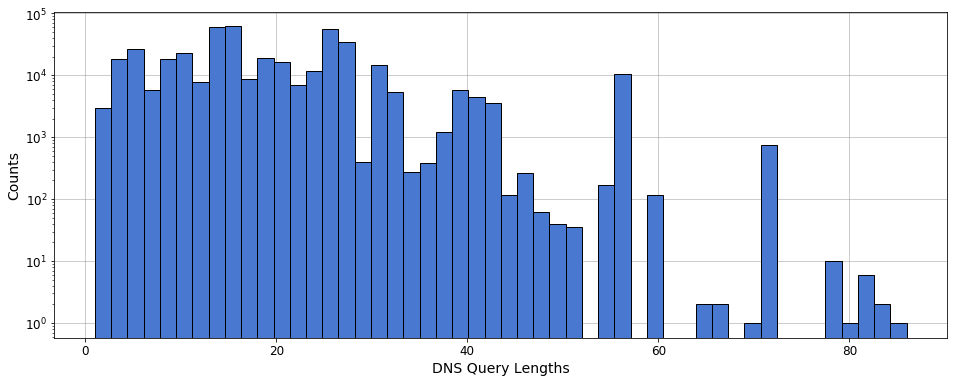

In [12]:
# Show histogram of the Spark DF request body lengths
bins, counts = spark_df.select('query_length').rdd.flatMap(lambda x: x).histogram(50)

# This is a bit awkward but I believe this is the correct way to do it
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.grid(True)
plt.xlabel('DNS Query Lengths')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

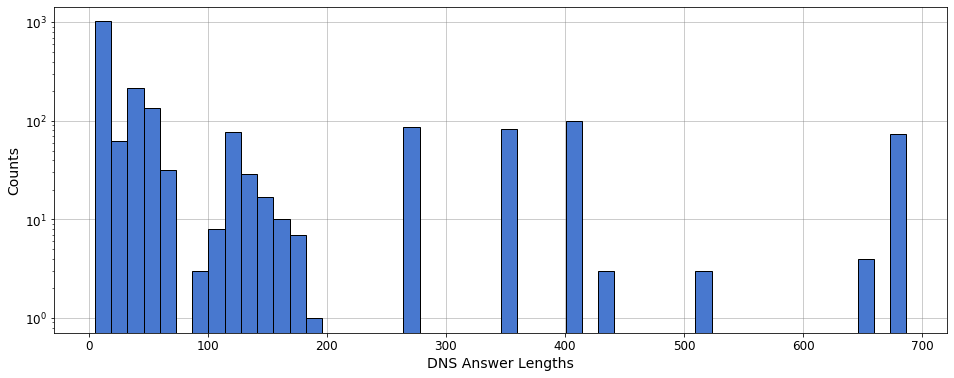

In [13]:
# Show histogram of the Spark DF request body lengths
bins, counts = spark_df.select('answer_length').rdd.flatMap(lambda x: x).histogram(50)

# This is a bit awkward but I believe this is the correct way to do it
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.grid(True)
plt.xlabel('DNS Answer Lengths')
plt.ylabel('Counts')

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/cleanup.jpeg" width="200px"></div>

# Cleanup
There are two bits of cleanup that we MUST do:
- Remove '.' from the column names (see Note:)
- Drop NULLs

**Note:** Yes you can do backticks when selecting the column names BUT some of the pipeline operations below will FAIL internally if the column names have a '.' in them.

In [14]:
# Replace '.' in the column names with '-'
nice_names = list(map(lambda x: x.replace('.', '_'), spark_df.columns))
spark_df = spark_df.toDF(*nice_names)

# Fill in NULL values
spark_df = spark_df.na.fill(0)   # For numeric columns
spark_df = spark_df.na.fill('-') # For string columns

<div style="float: right; margin: 50px 0px 0px 20px"><img src="images/pipelines.jpg" width="380px"></div>

# Spark Pipelines
A Spark pipeline is a way to combine a sequence of complex algorithms and transformations to create a workflow. Once a pipeline is created Spark can optimize that pipeline when it's executed.

Below our pipeline consists of the following stages:
- **String Indexer:** Takes our string columns and assigns an index to each unique string
- **OneHotEncoder:** Takes our string index and maps it to a bit vector
- **Normalization:** Converts our numeric data into a 0-1 range
- **Assembler:** Combines the encoded categorical data and numerical data into a combined matrix


For more information on the details of Categorical Type to One Hot Encoding see our SCP Labs [Encoding Dangers](https://nbviewer.jupyter.org/github/SuperCowPowers/scp-labs/blob/master/notebooks/Categorical_Encoding_Dangers.ipynb) notebook.

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler

cat_columns = ['qtype_name', 'proto']
num_columns = ['query_length', 'answer_length']
features = cat_columns + num_columns
stages = []

# String Indexer + One Hot Encoder (for categorical columns)
for cat_col in cat_columns:
    string_indexer = StringIndexer(inputCol=cat_col, outputCol=cat_col + '_index')
    encoder = OneHotEncoder(inputCol=cat_col + '_index', outputCol=cat_col + '_onehot')
    stages += [string_indexer, encoder]

# Run StandardScaler on all the numerical features
num_vector = VectorAssembler(inputCols=num_columns, outputCol = 'num_features')
norm = StandardScaler(inputCol='num_features', outputCol='num_features_norm')
stages += [num_vector, norm]

# Assemble the categorical (one hot vectors) and numeric columns together
assembler_inputs = [c + "_onehot" for c in cat_columns] + ['num_features_norm']
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')
stages += [assembler]

# Run the pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(spark_df)
spark_df = pipelineModel.transform(spark_df)

In [16]:
spark_df.select('features').show(truncate = False)

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|(16,[0,13,14],[1.0,1.0,2.2774453637337704])|
|(16,[0,13,14],[1.0,1.0,1.1842715891415605])|
|(16,[0,13,14],[1.0,1.0,1.457565032789613]) |
|(16,[0,13,14],[1.0,1.0,3.0062278801285767])|
|(16,[0,13,14],[1.0,1.0,1.3664672182402622])|
|(16,[0,13,14],[1.0,1.0,3.0062278801285767])|
|(16,[0,13,14],[1.0,1.0,1.457565032789613]) |
|(16,[0,13,14],[1.0,1.0,2.2774453637337704])|
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[0,13,14],[1.0,1.0,1.913054105536367]) |
|(16,[3,13,14],[1.0,1.0,2.45964099

In [23]:
from pyspark.ml.clustering import KMeans

# Train a k-means model.
kmeans = KMeans().setK(60)
model = kmeans.fit(spark_df)

In [24]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(spark_df)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 3660.3511003031267


In [25]:
# Lets look at some of the clustering results
transformed = model.transform(spark_df).select(features + ['prediction'])
transformed.groupby(cat_columns + ['prediction']).count().sort('prediction').show(50)

+----------+-----+----------+-----+
|qtype_name|proto|prediction|count|
+----------+-----+----------+-----+
|       PTR|  tcp|         0|   25|
|       PTR|  udp|         0|40370|
|        NB|  udp|         1|10282|
|      AXFR|  tcp|         2|  104|
|        NB|  udp|         3|24786|
|         A|  udp|         4|55907|
|         -|  udp|         5| 3255|
|         -|  tcp|         5|  163|
|      AAAA|  udp|         6| 9241|
|         A|  udp|         7| 6238|
|       PTR|  udp|         8|    6|
|      AXFR|  tcp|         8|   68|
|         A|  tcp|         9|    4|
|         A|  udp|         9|29310|
|       SRV|  udp|        10|10419|
|         A|  udp|        10|   58|
|       PTR|  udp|        11|11809|
|      AXFR|  tcp|        12|   74|
|         A|  udp|        13|15155|
|        NB|  udp|        14|11374|
|      AXFR|  tcp|        15|   25|
|       SOA|  udp|        15|  224|
|        NS|  udp|        15|   43|
|       SRV|  udp|        15|    4|
|      AAAA|  udp|        16

<div style="float: left; margin: 20px 20px 20px 20px"><img src="images/eyeball.jpeg" width="150px"></div>

# The clusters seem to look okay
We can see that there's some natural grouping/clusters around the different qtype_names and protocpls but we also see that many of the query types/protocols are in several clusters... so lets take a closer look at the 'TXT' queries (Note: Replace 'TXT', with any other type and feel free to explore the other 'sub-clusters')

In [26]:
# Lets look at the 'TXT' query_name clusters
txt_queries = transformed.where(transformed['qtype_name'] == 'TXT').groupby(features + ['prediction']).\
count().sort('prediction')
txt_queries.show(50)

+----------+-----+------------+-------------+----------+-----+
|qtype_name|proto|query_length|answer_length|prediction|count|
+----------+-----+------------+-------------+----------+-----+
|       TXT|  udp|          14|           17|        18|    1|
|       TXT|  udp|          24|            0|        18|    1|
|       TXT|  udp|          13|            0|        18|   31|
|       TXT|  udp|          22|            0|        18|   62|
|       TXT|  udp|           9|            0|        18|   21|
|       TXT|  udp|          12|            0|        18|  488|
|       TXT|  udp|          12|            5|        18|  214|
|       TXT|  udp|          23|            0|        18|   12|
|       TXT|  tcp|          12|            5|        18|  106|
|       TXT|  udp|          12|           12|        18|    1|
|       TXT|  tcp|          12|            0|        18|   24|
|       TXT|  udp|          13|            6|        18|   13|
|       TXT|  tcp|          12|           12|        18

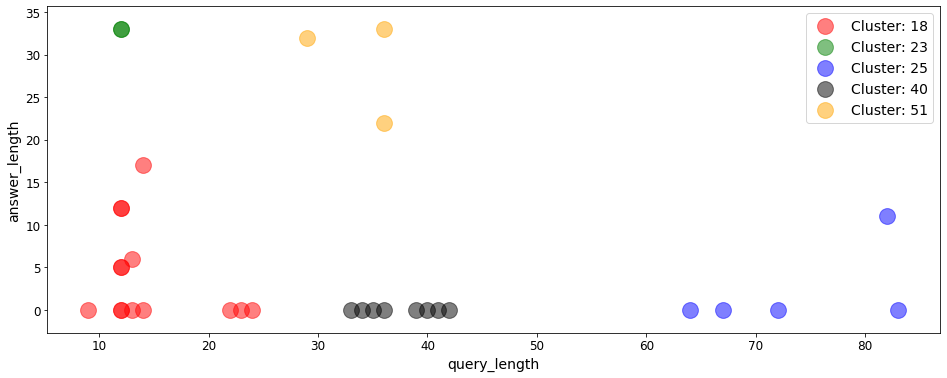

In [27]:
# The groupby/count produces a very small amount of data that 
# we can easily pull down and plot from our local client
import pandas as pd
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Convert to Pandas (make sure it's small)
txt_df = txt_queries.toPandas()

# Now use dataframe group by cluster
cluster_groups = txt_df.groupby('prediction')

# Plot the Machine Learning results
choices = ['red', 'green', 'blue', 'black', 'orange', 'purple', 'brown',
           'pink', 'lightblue', 'grey', 'yellow']
colors = {value: choices[index] for index, value in enumerate(txt_df['prediction'].unique())}

fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='query_length', y='answer_length', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

<div style="float: left; margin: 30px 30px 0px 0px"><img src="images/exploration.jpg" width="250px"></div>

## Interesting...
So we gave the clustering algorithm both categorical types and numerical types and it seems to have done a reasonable job using both, we can see that the categorical types are clustered and then within the categorical clustering we have a set of 'sub-clusters' based on the numerical values.

<img align="right" style="padding:20px" src="images/SCP_med.png" width="180">

## Wrap Up
Well that's it for this notebook, we pulled in Zeek log data from a Parquet file, then did some digging with high speed, parallel SQL operations and finally we clustered our data to organize the restuls.

If you liked this notebook please visit the [BAT](https://github.com/SuperCowPowers/bat) project for more notebooks and examples.

## About SuperCowPowers
The company was formed so that its developers could follow their passion for Python, streaming data pipelines and having fun with data analysis. We also think cows are cool and should be superheros or at least carry around rayguns and burner phones. <a href="https://www.supercowpowers.com" target="_blank">Visit SuperCowPowers</a>